In [1]:
from os import listdir, path
import numpy as np
import scipy, cv2, os, sys, argparse, audio
import json, subprocess, random, string
from tqdm import tqdm
from glob import glob
import torch, face_detection
from models import Wav2Lip
import platform

In [2]:
# loading video

video_file = "test.mov"

resize_factor = 2
rotate = False

video_stream = cv2.VideoCapture(video_file)
fps = video_stream.get(cv2.CAP_PROP_FPS)
full_frames = []

while 1:
    still_reading, frame = video_stream.read()
    if not still_reading:
        video_stream.release()
        break
    if resize_factor > 1:
        frame = cv2.resize(frame, (frame.shape[1] // resize_factor, frame.shape[0] // resize_factor))

    if rotate:
        frame = cv2.rotate(frame, cv2.cv2.ROTATE_90_CLOCKWISE)

    full_frames.append(frame)


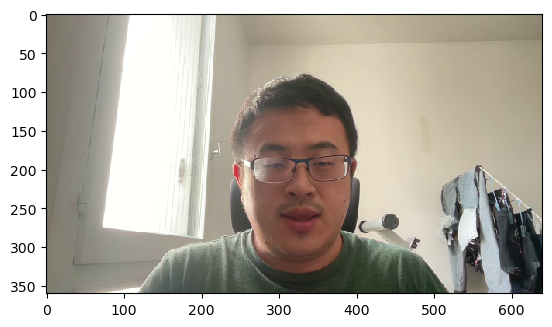

In [14]:
from matplotlib import pyplot as plt

plt.imshow(np.stack(
    [full_frames[0][:, :, 2], full_frames[0][:, :, 1], full_frames[0][:, :, 0]], 2
), interpolation='nearest')
plt.show()


In [39]:
302 / (80. / fps)

113.26132613261326

In [40]:
# load audio

audio_file = "test.m4a"
sampling_rate = 16000

if not audio_file.endswith('.wav'):
    print('Extracting raw audio...')
    command = 'ffmpeg -y -i {} -strict -2 {}'.format(audio_file, 'temp/temp.wav')

    subprocess.call(command, shell=True)
    audio_file = 'temp/temp.wav'
    
wav = audio.load_wav(audio_file, sampling_rate)
mel = audio.melspectrogram(wav)
print(mel.shape)

mel_chunks = []
mel_idx_multiplier = mel.shape[0] / fps
mel_step_size = 16
i = 0

while 1:
    start_idx = int(i * mel_idx_multiplier)
    if start_idx + mel_step_size > len(mel[0]):
        mel_chunks.append(mel[:, len(mel[0]) - mel_step_size:])
        break
    mel_chunks.append(mel[:, start_idx : start_idx + mel_step_size])
    i += 1

print("Length of mel chunks: {}".format(len(mel_chunks)))

Extracting raw audio...
(80, 318)
Length of mel chunks: 115


ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.0.40.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-l

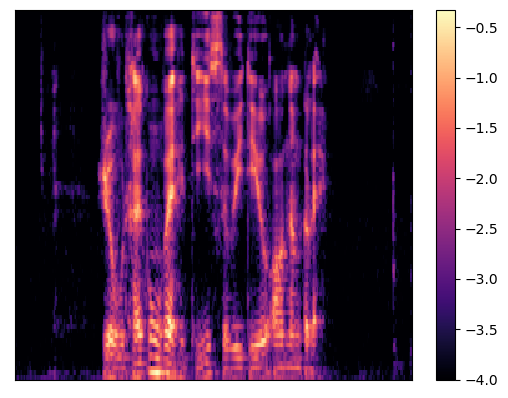

In [35]:
import librosa
import librosa.display

plt.figure()
librosa.display.specshow(mel)
plt.colorbar()


In [64]:

def get_smoothened_boxes(boxes, T):
    for i in range(len(boxes)):
        if i + T > len(boxes):
            window = boxes[len(boxes) - T:]
        else:
            window = boxes[i : i + T]
        boxes[i] = np.mean(window, axis=0)
    return boxes

def face_detect(images, device = 'cpu', batch_size = 16, pads = [0, 10, 0, 0]):
    detector = face_detection.FaceAlignment(face_detection.LandmarksType._2D, flip_input=False, device=device)

    rects = []
    pady1, pady2, padx1, padx2 = pads
    shape = images[0].shape
    for i in tqdm(range(0, len(images), batch_size)):
        rect = detector.get_detections_for_batch(np.array(images[i:i + batch_size]))[0]
        y1 = max(0, rect[1] - pady1)
        y2 = min(shape[0], rect[3] + pady2)
        x1 = max(0, rect[0] - padx1)
        x2 = min(shape[1], rect[2] + padx2)

        rects.append(np.array([x1, y1, x2, y2]))

    face_images = [image[y1: y2, x1:x2] for image, (x1, y1, x2, y2) in zip(images, rects)]

    del detector
    return face_images, rects 

def datagen(frames, mels, batch_size = 128, img_size = 96):
    face_batch, coords_batch = [], [],

    face_images, rects = face_detect(frames, batch_size = 128)

    resized_face_images = [
        cv2.resize(image, (img_size, img_size))
        for image in face_images
    ]
    
    for i in range(0, len(resized_face_images), batch_size):
        yield (
            np.asarray(resized_face_images[i: i + batch_size]),
            np.asarray(mels[i: i + batch_size]),
            frames[i: i + batch_size],
            rects[i: i + batch_size]
        )

selected_full_frames = full_frames[:len(mel_chunks)]

batch_size = 128
gen = datagen(selected_full_frames, mel_chunks)

In [65]:
device = 'cpu'

def _load(checkpoint_path):
    if device == 'cuda':
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path,
                                map_location=lambda storage, loc: storage)
    return checkpoint

def load_model(path):
    model = Wav2Lip()
    print("Load checkpoint from: {}".format(path))
    checkpoint = _load(path)
    s = checkpoint["state_dict"]
    new_s = {}
    for k, v in s.items():
        new_s[k.replace('module.', '')] = v
    model.load_state_dict(new_s)

    model = model.to(device)
    return model.eval()

model = load_model("./wav2lip.pth")

for i, (img_batch, mel_batch, frames, coords) in enumerate(
    tqdm(gen, total=int(np.ceil(float(len(mel_chunks))/batch_size)))):
    
    img_batch = torch.FloatTensor(np.transpose(img_batch, (0, 3, 1, 2))).to(device)
    mel_batch = torch.FloatTensor(np.transpose(mel_batch, (0, 3, 1, 2))).to(device)

    with torch.no_grad():
        pred = model(mel_batch, img_batch)

    pred = pred.cpu().numpy().transpose(0, 2, 3, 1) * 255.

    for p, f, c in zip(pred, frames, coords):
        y1, y2, x1, x2 = c
        p = cv2.resize(p.astype(np.uint8), (x2 - x1, y2 - y1))

        f[y1:y2, x1:x2] = p
        out.write(f)

out.release()

command = 'ffmpeg -y -i {} -i {} -strict -2 -q:v 1 {}'.format(args.audio, 'temp/result.avi', args.outfile)
subprocess.call(command, shell=platform.system() != 'Windows')
    
    
    

Load checkpoint from: ./wav2lip.pth


  0%|                                                                                                                                                                                                   | 0/1 [03:50<?, ?it/s]


ValueError: axes don't match array

In [71]:
img_batch.shape

torch.Size([1, 3, 96, 96])